# Objective

This notebook will use **scikit-learn** and **Cost Complexity Pruning** to build a **classification tree** which uses continous and categorical data from the [UCI Machine Learning Respository](https://archive.ics.uci.edu/) to predict whether or not a patient has [heart disease](https://archive.ics.uci.edu/dataset/45/heart+disease).

## Dataset Information

**Attributes used:** <br>
      1.(age)       
      2.(sex)       
      3.(cp)        
      4.(trestbps)  
      5.(chol)      
      6.(fbs)       
      7.(restecg)   
      8.(thalach)   
      9.(exang)     
      10 (oldpeak)   
      11 (slope)     
      12 (ca)        
      13 (thal)      
      14 (num)(the predicted attribute)

**Attributes Description:** <br>
- age: age in years
- sex: sex (1 = male; 0 = female)
- cp: chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic


- restbps: resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholestoral in mg/dl
- fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
-  restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

- thalach: maximum heart rate achieved
- exang: exercise induced angina (1 = yes; 0 = no)
-  oldpeak = ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping

-  ca: number of major vessels (0-3) colored by flourosopy
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
- num: diagnosis of heart disease (angiographic disease status)



### Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

### Import the Data

In [2]:
df = pd.read_csv('processed.cleveland.data', header=None)

In [3]:
df.head()

0    1    2      3      4    5    6      7    8    9    10   11   12  13
0  63.0  1.0  1.0  145.0  233.0  1.0  2.0  150.0  0.0  2.3  3.0  0.0  6.0   0
1  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0   2
2  67.0  1.0  4.0  120.0  229.0  0.0  2.0  129.0  1.0  2.6  2.0  2.0  7.0   1
3  37.0  1.0  3.0  130.0  250.0  0.0  0.0  187.0  0.0  3.5  3.0  0.0  3.0   0
4  41.0  0.0  2.0  130.0  204.0  0.0  2.0  172.0  0.0  1.4  1.0  0.0  3.0   0

In [4]:
df.columns = [
    "age",
    "sex",
    "cp",
    "trestbps",
    "chol",
    "fbs",
    "restecg",
    "thalach",
    "exang",
    "oldpeak",
    "slope", 
    "ca", 
    "thal",
    "hd"]

df.head()

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  hd  
0    3.0  0.0  6.0   0  
1    2.0  3.0  3.0   2  
2    2.0  2.0  7.0   1  
3    3.0  0.0  3.0   0  
4    1.0  0.0  3.0   0

### Identify Missing Data

In [5]:
df.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
hd            int64
dtype: object

In [9]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
hd          0
dtype: int64

We see that all columns have no missing data. However since the **thal** and **ca** columns are string features, lets have a closer look at them to make sure if missing values have been replaced by a string.

In [6]:
df["ca"].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

We see that **ca** contains numbers (0.0, 3.0, 2.0 and 1.0) and question marks (?). The numbers represent the number of blood vessels that were lit up by the fluoroscopy and the question marks represent missing data.

In [7]:
df["thal"].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

Again, **thal** also contains mixture of numbers, representing the different diagnoses from the thalium heart scan, and question marks, which represent missing values.

In [10]:
# Let's see the number of missing values in 'ca' and 'thal'

len(df[(df['ca'] == '?') | (df['thal'] == '?')])

6

In [11]:
# Let's look at these 6 rows
df[(df['ca'] == '?') | (df['thal'] == '?')]

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
87   53.0  0.0  3.0     128.0  216.0  0.0      2.0    115.0    0.0      0.0   
166  52.0  1.0  3.0     138.0  223.0  0.0      0.0    169.0    0.0      0.0   
192  43.0  1.0  4.0     132.0  247.0  1.0      2.0    143.0    1.0      0.1   
266  52.0  1.0  4.0     128.0  204.0  1.0      0.0    156.0    1.0      1.0   
287  58.0  1.0  2.0     125.0  220.0  0.0      0.0    144.0    0.0      0.4   
302  38.0  1.0  3.0     138.0  175.0  0.0      0.0    173.0    0.0      0.0   

     slope   ca thal  hd  
87     1.0  0.0    ?   0  
166    1.0    ?  3.0   0  
192    2.0    ?  7.0   1  
266    2.0  0.0    ?   2  
287    2.0    ?  7.0   0  
302    1.0    ?  3.0   0

In [12]:
# Let's see these missing value count as a percentage of the whole dataset
perc_missing = (len(df[(df['ca'] == '?') | (df['thal'] == '?')])/len(df)) * 100
perc_missing

1.9801980198019802

Since less than 2% of the data is missing we will remove the rows

In [13]:
df_no_missing = df[(df['ca'] != '?') & (df['thal'] != '?')]
df_no_missing

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1    67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2    67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3    37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4    41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
..    ...  ...  ...       ...    ...  ...      ...      ...    ...      ...   
297  57.0  0.0  4.0     140.0  241.0  0.0      0.0    123.0    1.0      0.2   
298  45.0  1.0  1.0     110.0  264.0  0.0      0.0    132.0    0.0      1.2   
299  68.0  1.0  4.0     144.0  193.0  1.0      0.0    141.0    0.0      3.4   
300  57.0  1.0  4.0     130.0  131.0  0.0      0.0    115.0    1.0      1.2   
301  57.0  0.0  2.0     130.0  236.0  0.0      2.0    174.0    0.0      0.0   

     slope   ca thal  hd  
0      3.0  0.0  6.0   0  
1      2.0  3.0  3.0   2  
2      2.0  2.0  7.0   1  
3      3.0  0.0  3.0   0  
4      1.0  0.0  3.0   0  
..     ...  ...  ...  ..  
297    2.0  0.0  7.0   1  
298    2.0  0.0  7.0   1  
299    2.0  2.0  7.0   2  
300    2.0  1.0  7.0   3  
301    2.0  1.0  3.0   1  

[297 rows x 14 columns]

In [14]:
len(df_no_missing)

297

In [15]:
df_no_missing['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0'], dtype=object)

In [16]:
df_no_missing['thal'].unique()

array(['6.0', '3.0', '7.0'], dtype=object)

We have removed all the missing values in the dataset

### Check for Duplicate Values

In [20]:
df_no_missing.duplicated().sum()

0

There are no duplicate values in this dataset

### Split the Data into Dependent and Independent Variables

In [21]:
X = df_no_missing.drop('hd', axis=1).copy()
X.head()

age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  
0    3.0  0.0  6.0  
1    2.0  3.0  3.0  
2    2.0  2.0  7.0  
3    3.0  0.0  3.0  
4    1.0  0.0  3.0

In [22]:
y = df_no_missing['hd'].copy()
y.head()

0    0
1    2
2    1
3    0
4    0
Name: hd, dtype: int64

### Feature Engineering

In [23]:
X.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
dtype: object

From the attributes description provided at the beginning of the notebook, we see that some of these columns should be categorical and some numeric. Therefore, we should correct the datatypes if needed for each column and then apply one hot encoding on the categorical features to get our dummy variables.

In [27]:
X['sex'].unique()

array([1., 0.])

In [28]:
X['cp'].unique()

array([1., 4., 3., 2.])

In [29]:
X['fbs'].unique()

array([1., 0.])

In [30]:
X['restecg'].unique()

array([2., 0., 1.])

In [32]:
X['exang'].unique()

array([0., 1.])

All the categorical variables have the expected unique values in them so these columns can now be one-hot encoded. We don't need to do this for the age column since they are already categorically defined using 1 and 0. We will use pd.get_dummies() to create the dummy variables.

In [34]:
X_encoded = pd.get_dummies(X, columns=["cp", "restecg", "slope", "thal"], dtype=int)

X_encoded.head()

age  sex  trestbps   chol  fbs  thalach  exang  oldpeak   ca  cp_1.0  ...  \
0  63.0  1.0     145.0  233.0  1.0    150.0    0.0      2.3  0.0       1  ...   
1  67.0  1.0     160.0  286.0  0.0    108.0    1.0      1.5  3.0       0  ...   
2  67.0  1.0     120.0  229.0  0.0    129.0    1.0      2.6  2.0       0  ...   
3  37.0  1.0     130.0  250.0  0.0    187.0    0.0      3.5  0.0       0  ...   
4  41.0  0.0     130.0  204.0  0.0    172.0    0.0      1.4  0.0       0  ...   

   cp_4.0  restecg_0.0  restecg_1.0  restecg_2.0  slope_1.0  slope_2.0  \
0       0            0            0            1          0          0   
1       1            0            0            1          0          1   
2       1            0            0            1          0          1   
3       0            1            0            0          0          0   
4       0            0            0            1          1          0   

   slope_3.0  thal_3.0  thal_6.0  thal_7.0  
0          1         0         1         0  
1          0         1         0         0  
2          0         0         0         1  
3          1         1         0         0  
4          0         1         0         0  

[5 rows x 22 columns]

In [35]:
y.unique()

array([0, 2, 1, 3, 4], dtype=int64)

We see that our y variable contains 5 different levels of heart disease. Since we are creating a simpple decision tree classifier, and only care if someone has heart disease or not, we need to convert all numbers > 0 to 1.

In [36]:
y[y > 0] = 1
y.unique()

array([0, 1], dtype=int64)

## Build a Preliminary Classification Tree

In [57]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.33, random_state=42)

clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)

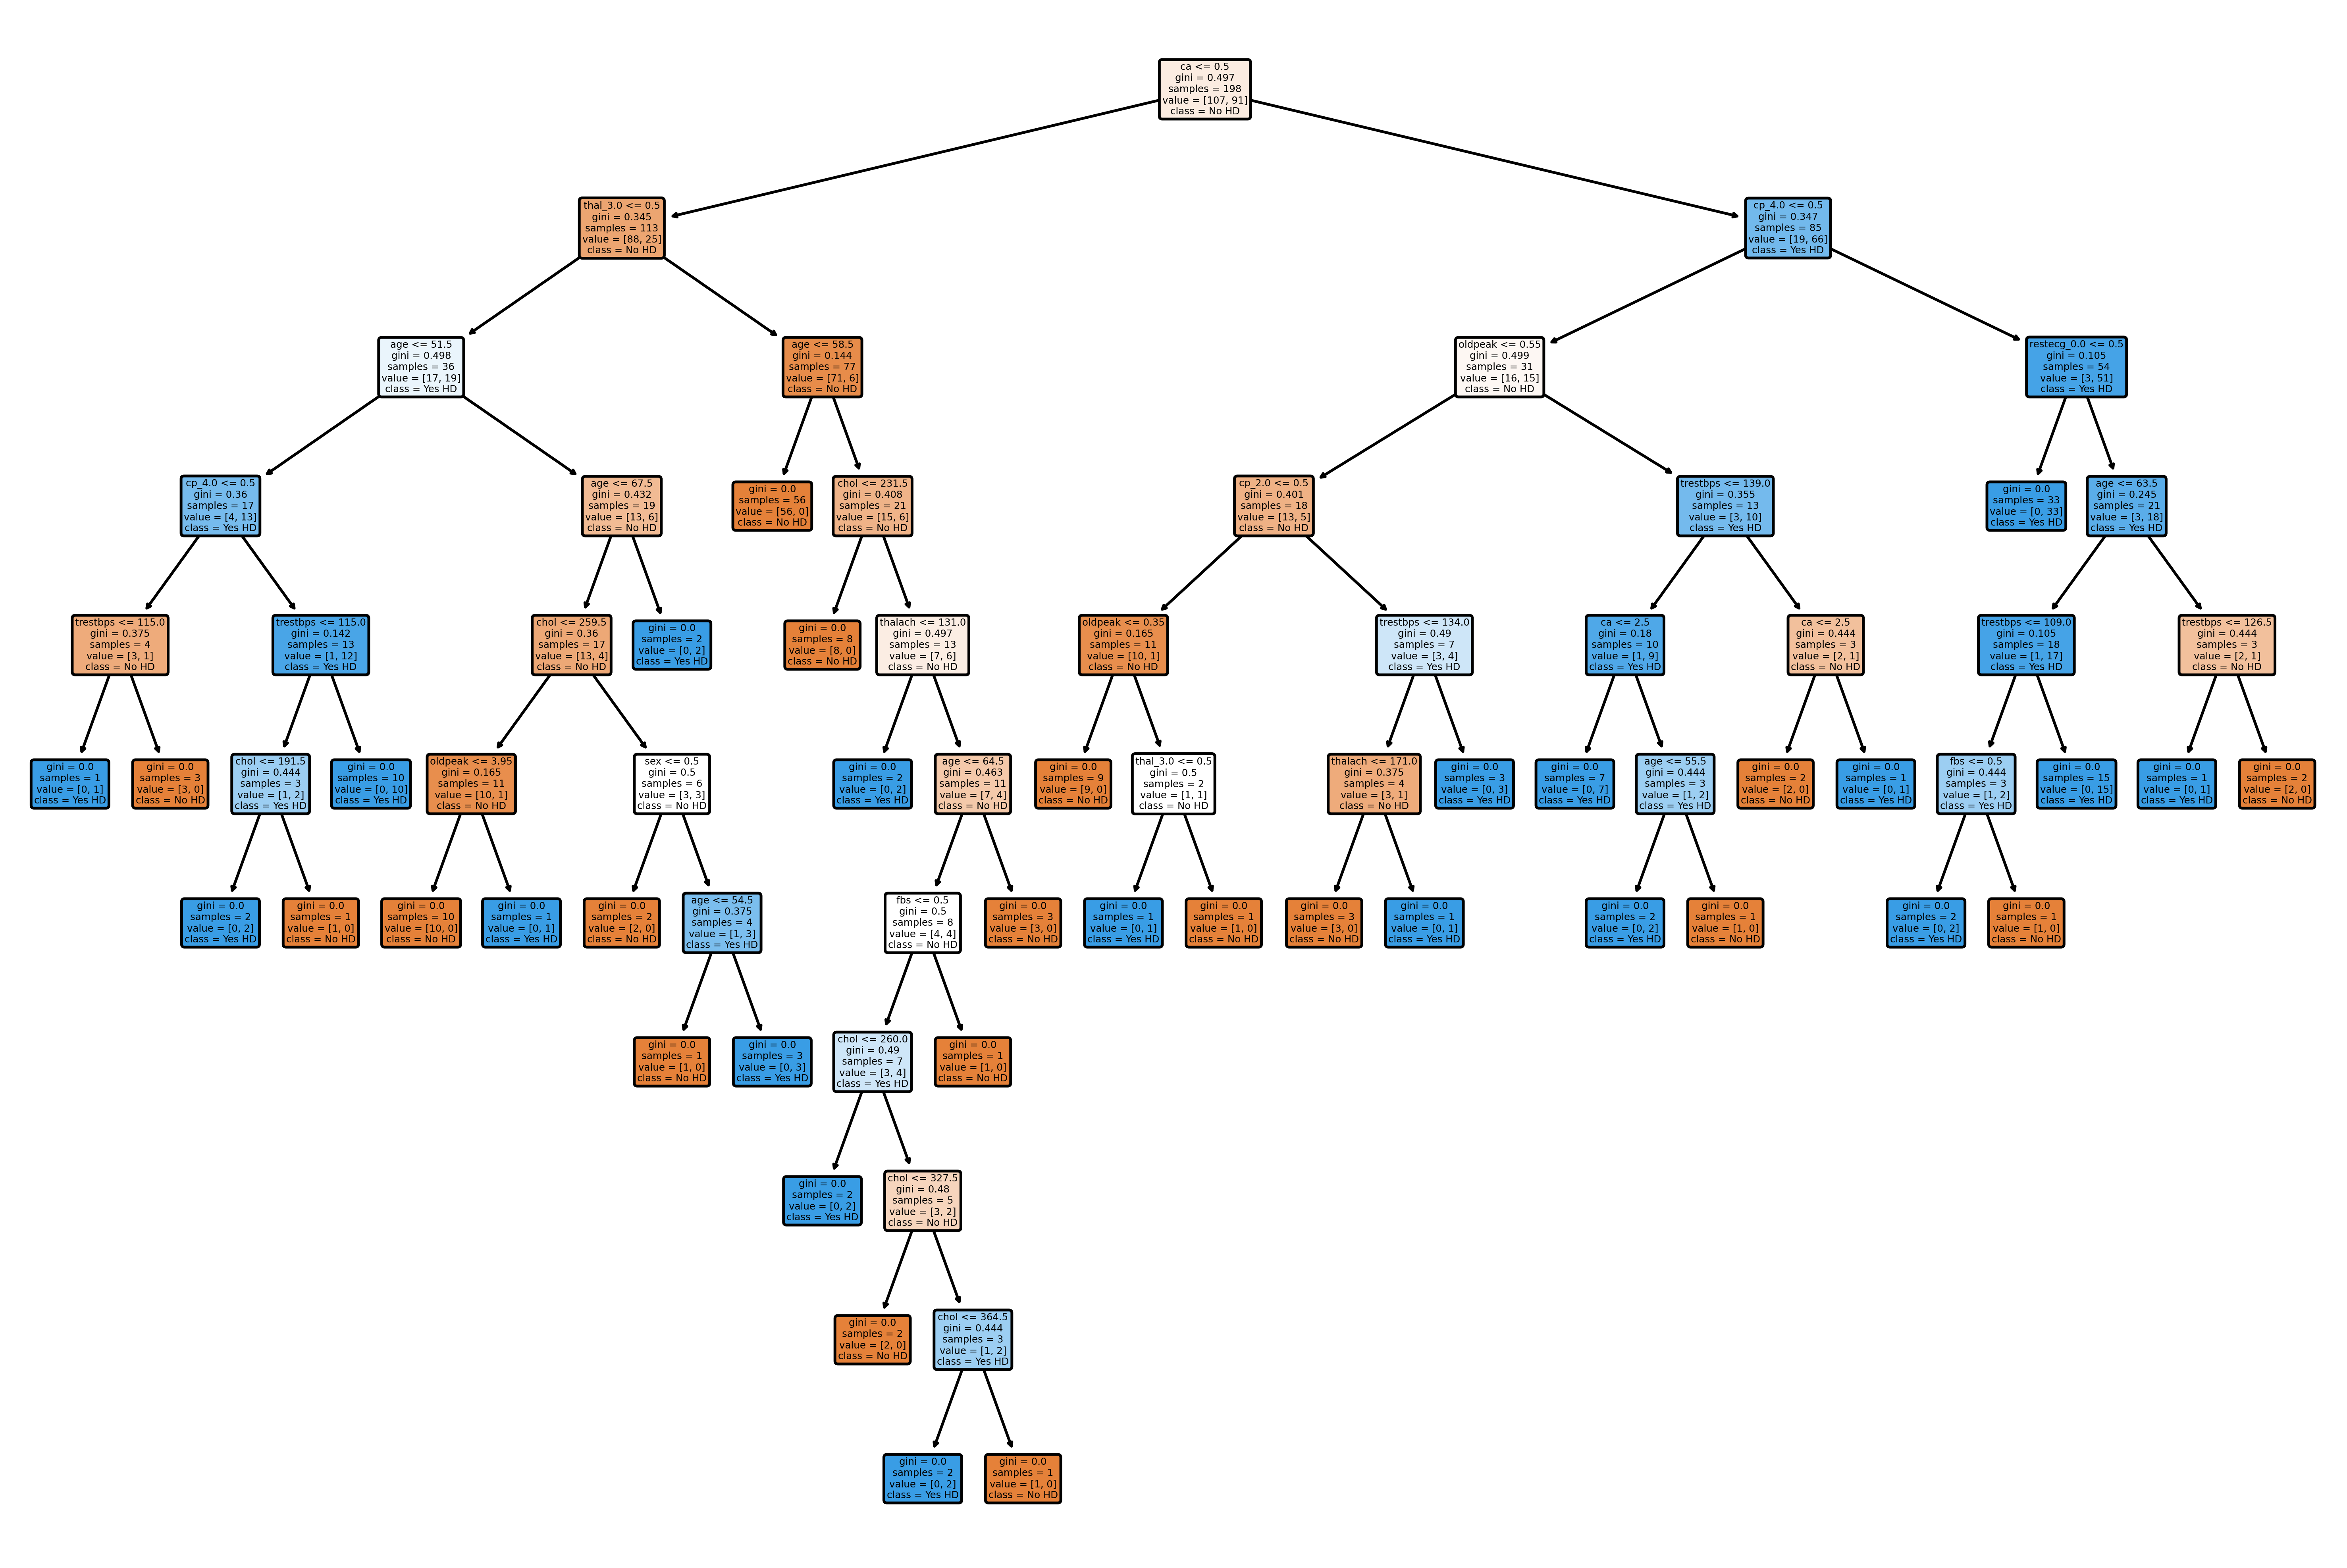

In [42]:
# plot the tree
plt.figure(figsize=(15, 10), dpi=500)
plot_tree(clf_dt, filled=True, rounded=True,
          class_names=["No HD", "Yes HD"],
          feature_names=list(X_encoded.columns))

plt.show()



Let's see how this classification tree performs on the **Training Dataset** by drawing a **Confusion Matrix**.

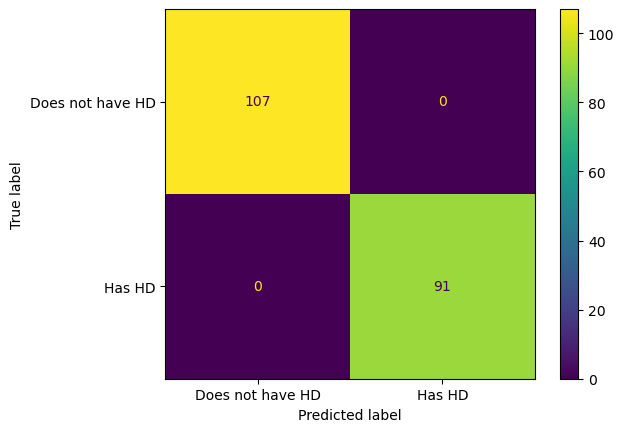

In [44]:
# ConfusionMatrixDisplay.from_estimator() will run the train data down the tree and draw
# a confision matrix

ConfusionMatrixDisplay.from_estimator(estimator=clf_dt, X=X_train, y=y_train, display_labels=["Does not have HD", "Has HD"])

Seems like the decision tree has perfectly classified both the people with and without heart disease. Seems like we have overfit on the training data. Let's confirm this by similarly checking the performance of the tree on the test data.

Let's see how this classification tree performs on the **Testing Dataset** by running the **Testing Dataset** down the tree and drawing a **Confusion Matrix**.

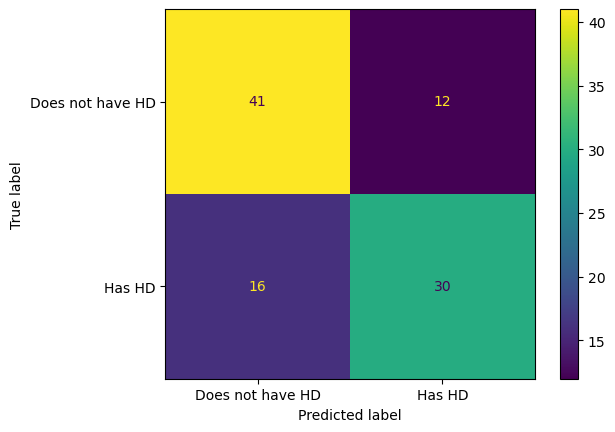

In [45]:
# ConfusionMatrixDisplay.from_estimator() will run the test data down the tree and draw
# a confision matrix

ConfusionMatrixDisplay.from_estimator(estimator=clf_dt, X=X_test, y=y_test, display_labels=["Does not have HD", "Has HD"])

In the confusion matrix we see that out of the 53 people that did not have heart disease, 41 (77%) were correctly classified. And of the 46 people that had heart disease, 30 (65%) were correctly identified. Since the model has performed relatively poorly on the test data and perfectly on the training data, we have overfit the tree on the training set. We will need to prune the tree in order to overcome this overfitting problem.

## Cost Complexity Pruning

First, let's extract the different values of `alpha` that are available for this tree and build a pruned tree for each value of alpha. **NOTE:** We omit the maximum value for alpha with `ccp_alphas = ccp_alphas[:-1]` because it would prune all the leaves, leaving us with only the root node of the tree.

In [46]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) #determine values for alpha
ccp_alphas = path.ccp_alphas # extract different values for alpha
ccp_alphas = ccp_alphas[:-1] # exclude the maximum alpha value

clf_dts = [] # create an array that we will put the decision trees into

# now create one decision tree per alpha value and store it in the array
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

Now let's graph the accuracy of the trees using the **Training Dataset** and the **Testing Dataset** as a function of alpha.

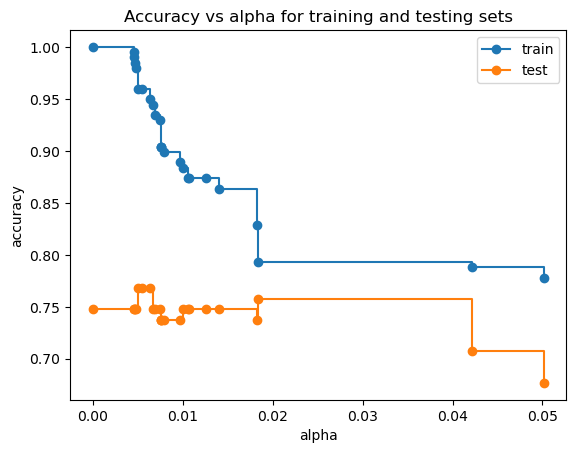

In [48]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()



In the graph above, we see that the accuracy for the **Testing Dataset** hits its maximum value when `alpha` is about **0.005**. After this value for `alpha`, the accuracy of the Training Dataset drops significantly so we shouldn't use this value. The next highest value for `alpha` w.r.t to the **Testing Dataset** is around **0.018** and after this the value the **Training Dataset** accuracy remains constant so that suggests we should set `ccp_alpha=0.018`

We will also apply 5-Fold Cross Validation. 

## Cross Validation For Finding the Best Alpha

The graph we just plotted suggested one value for alpha, **0.018**, but another set of data might suggest another potimal value. So instead of picking a single **Training** and **Testing** dataset, let's use **cross-validation** to fing the optimal value for `ccp_alpha`.


<Axes: xlabel='alpha'>

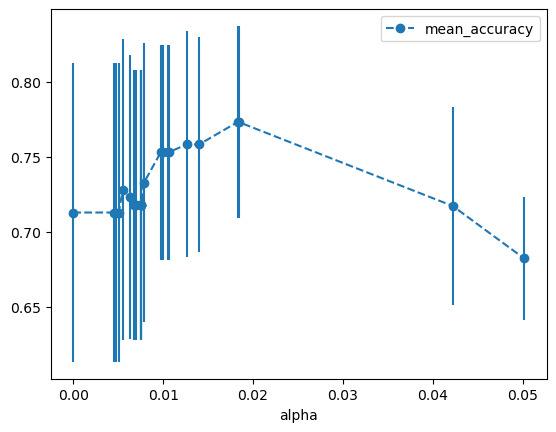

In [49]:
# create an array to store the results of each fold during cross validation
alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

# Now we can plot the means and standard deviations for the scores of each candidate alpha value
alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr='std',
                   marker='o',
                   linestyle='--')

With the above plot we have confirmed that indeed **0.018** was the optimal value for this case. Let's find the exact value:

In [50]:
alpha_results[(alpha_results['alpha'] > 0.017) & (alpha_results['alpha'] < 0.02)]

alpha  mean_accuracy       std
21  0.018264       0.773077  0.064145
22  0.018415       0.773077  0.064145

Since both alpha values have the same accuracy we will just take the first one.

In [51]:
ideal_ccp_alpha = 0.018264

### Building, Evaluating, Drawing and Interpreting Optimised Classification Tree

In [54]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42,
                                       ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)


#### Train Set Confusion Matrix

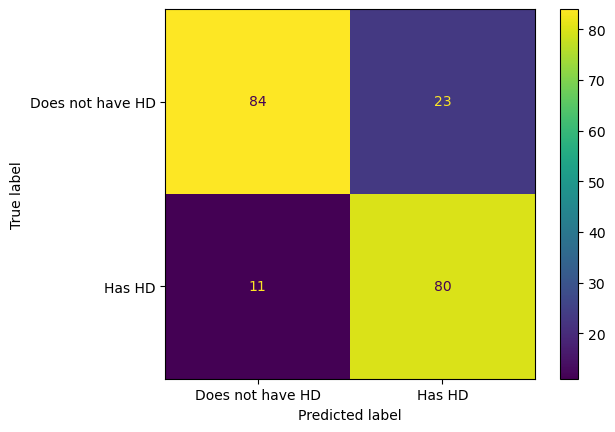

In [55]:
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_train, y_train, display_labels=["Does not have HD", "Has HD"])

We see now that our decision tree isn't perfectly classifying all our labels which is a good sign.

Out of the 107 people that did not have heart disease, 84(79%) were correctly classified.

Out of the 91 people that had heart disease, 80 (88%) were classified correctly. 

#### Test Set Confusion Matrix

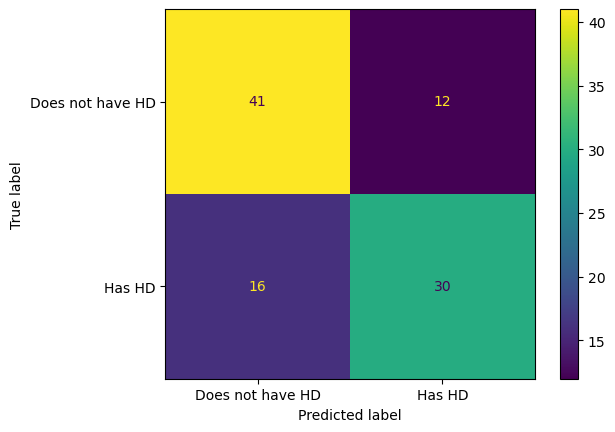

In [58]:
# lets plot the confusion matrix for the base tree model again for comparison
ConfusionMatrixDisplay.from_estimator(estimator=clf_dt, X=X_test, y=y_test, display_labels=["Does not have HD", "Has HD"])

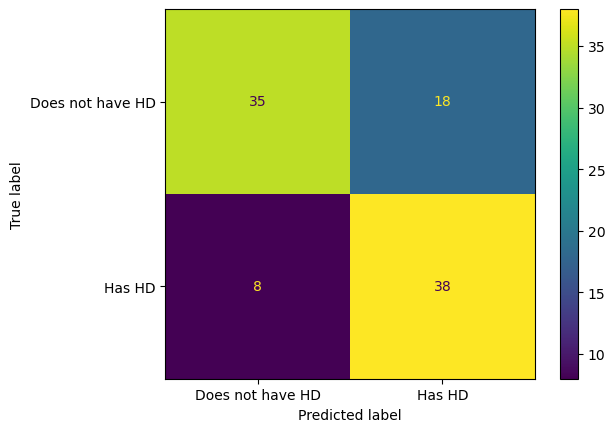

In [56]:
ConfusionMatrixDisplay.from_estimator(clf_dt_pruned, X_test, y_test, display_labels=["Does not have HD", "Has HD"])

Out of the 53 people that did not have heart disease, 35(66%). This is a slight decrease in accuracy from the base model for true negatives.

Out of the 46 people who had heart disease, 38 (83%) were classified correctly. This is an improvement from the base model in terms of our True positives.

For this particular case where we are diagnosing people for heart disease, it makes sense to focus on reducing False negative results as misdiagnosing a patient with heart disease can be dangerous. The optimised model reduced the amount of false negatives significantly w.r.t to the base model. For this model the True negatives accuracy was quite low but this may be acceptable in this case as we would rather be less accurate in diagnosing someone who doesn't have heart disease as opposed to misdiagnosing someone who actually has the disease. 

Last thing we will do is draw the pruned tree

#### Base model tree plot

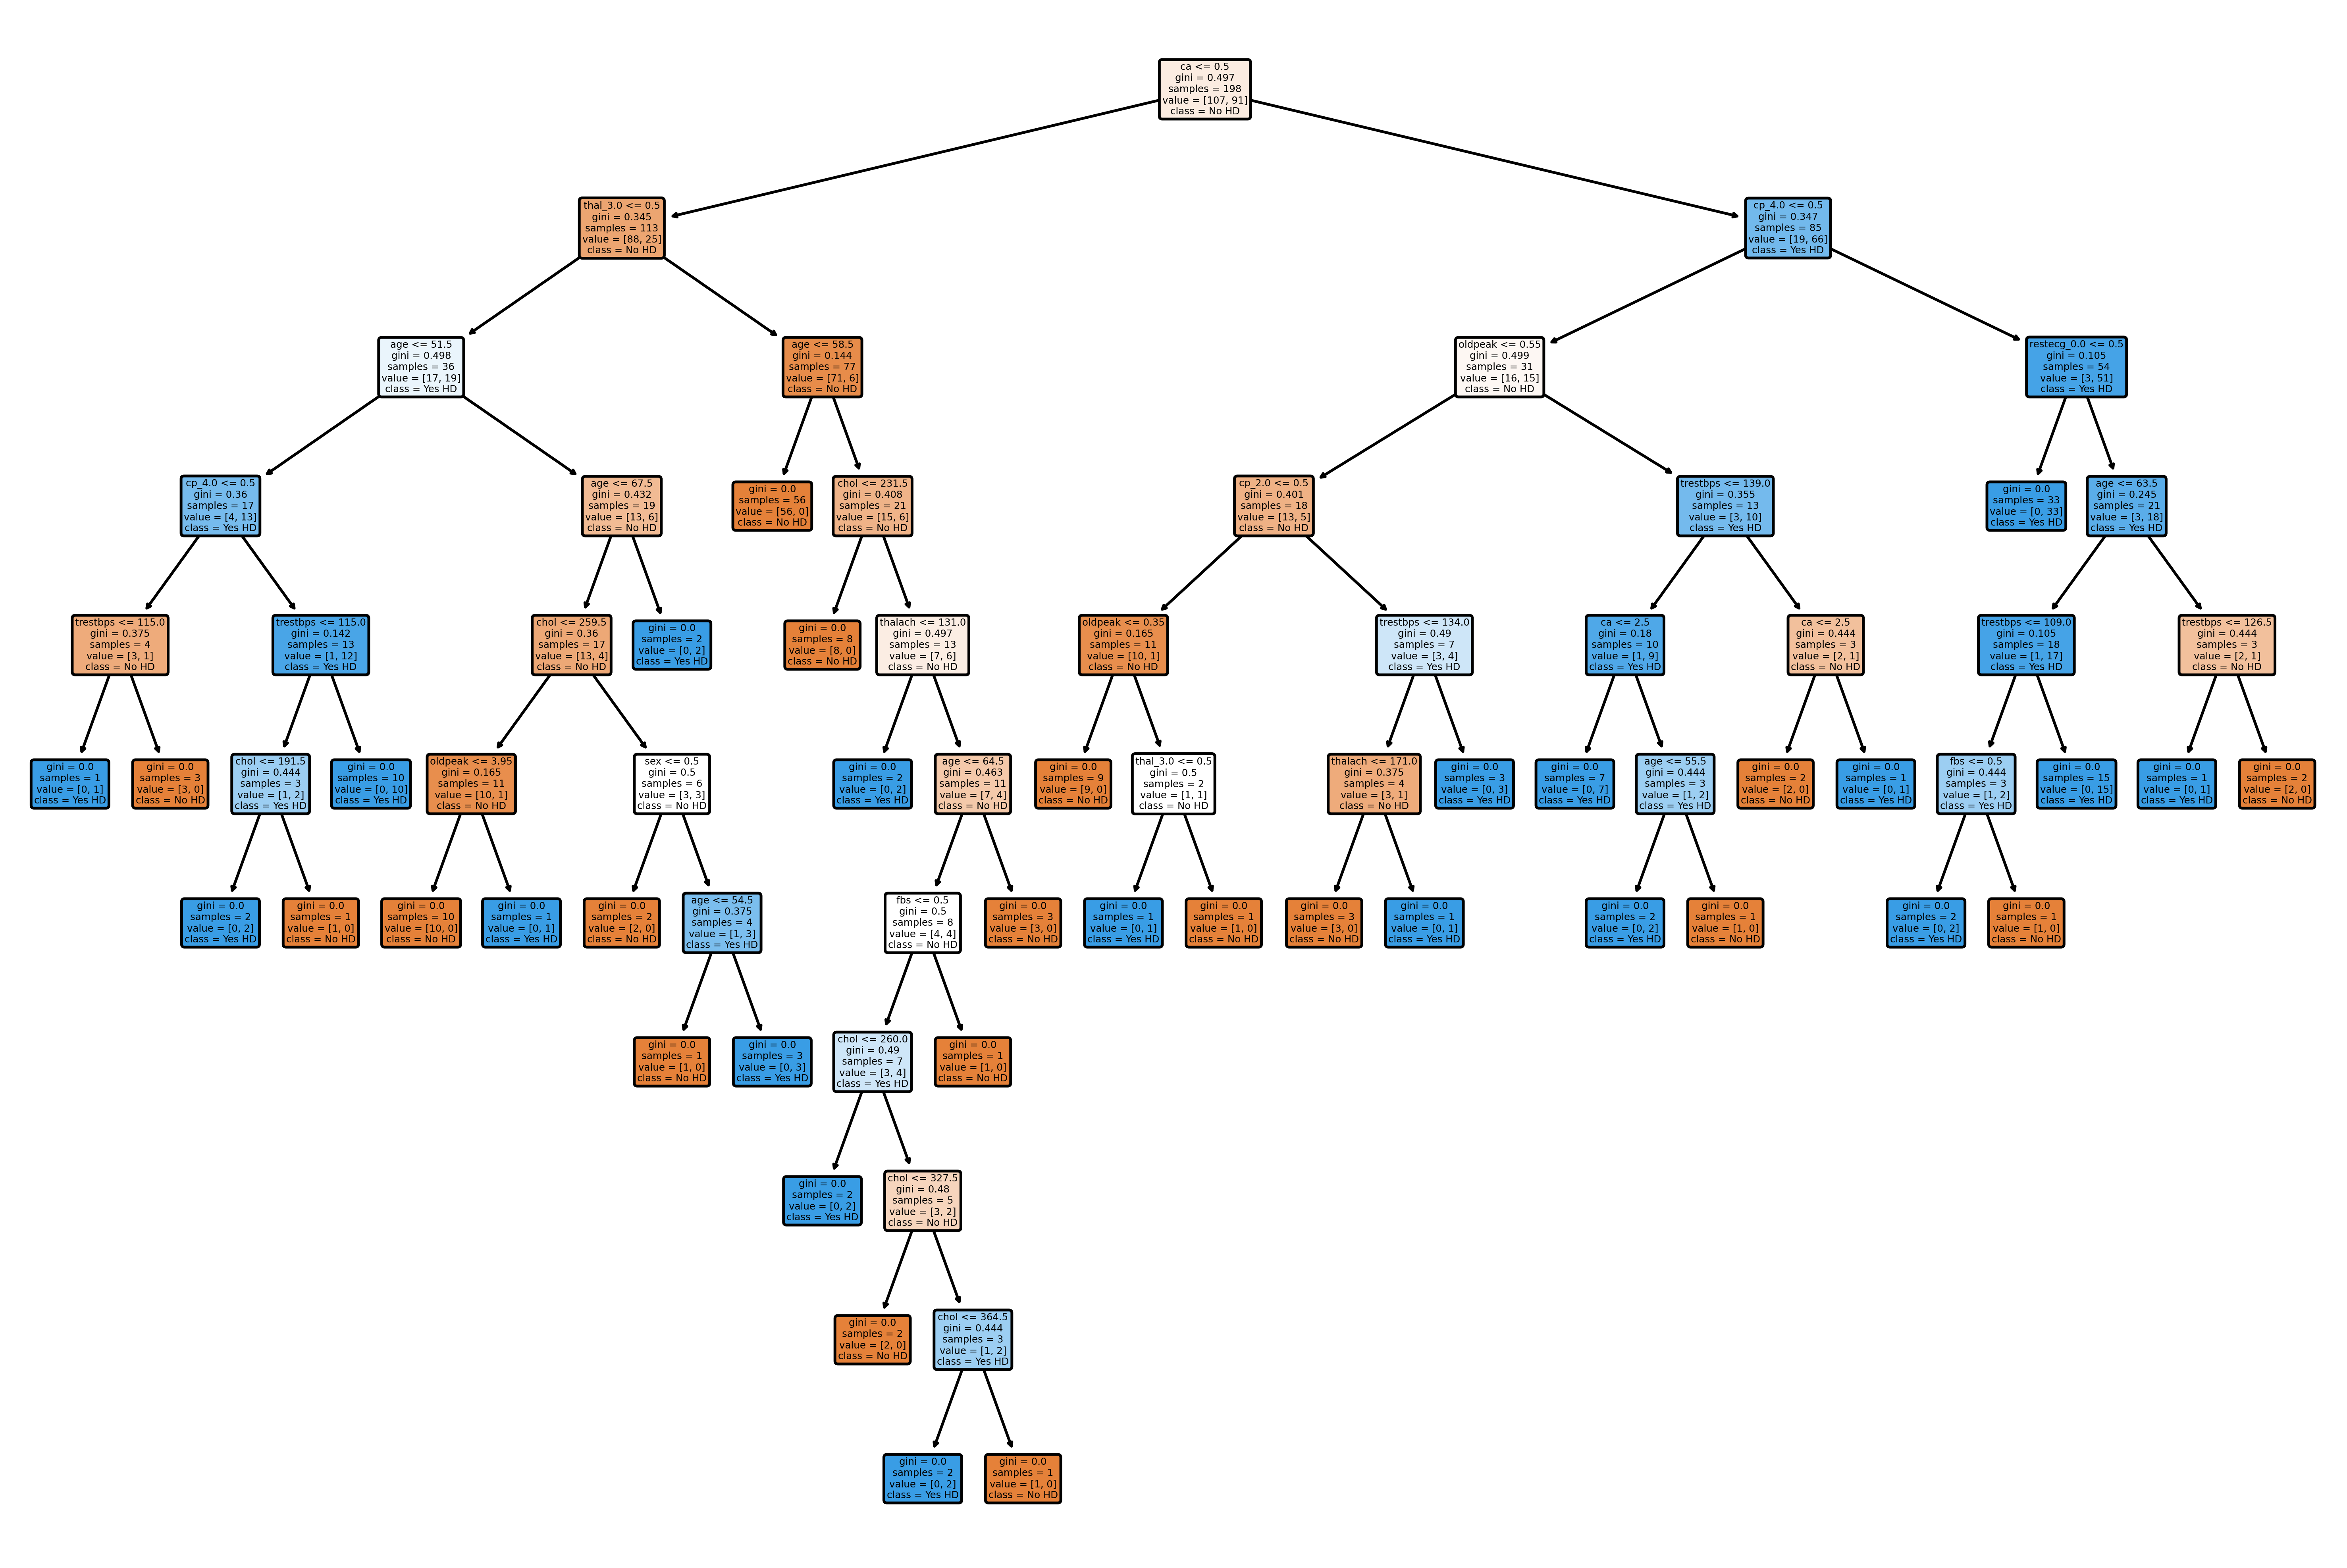

In [59]:
plt.figure(figsize=(15, 10), dpi=500)
plot_tree(clf_dt, filled=True, rounded=True,
          class_names=["No HD", "Yes HD"],
          feature_names=list(X_encoded.columns))

plt.show()

#### Pruned Tree Plot

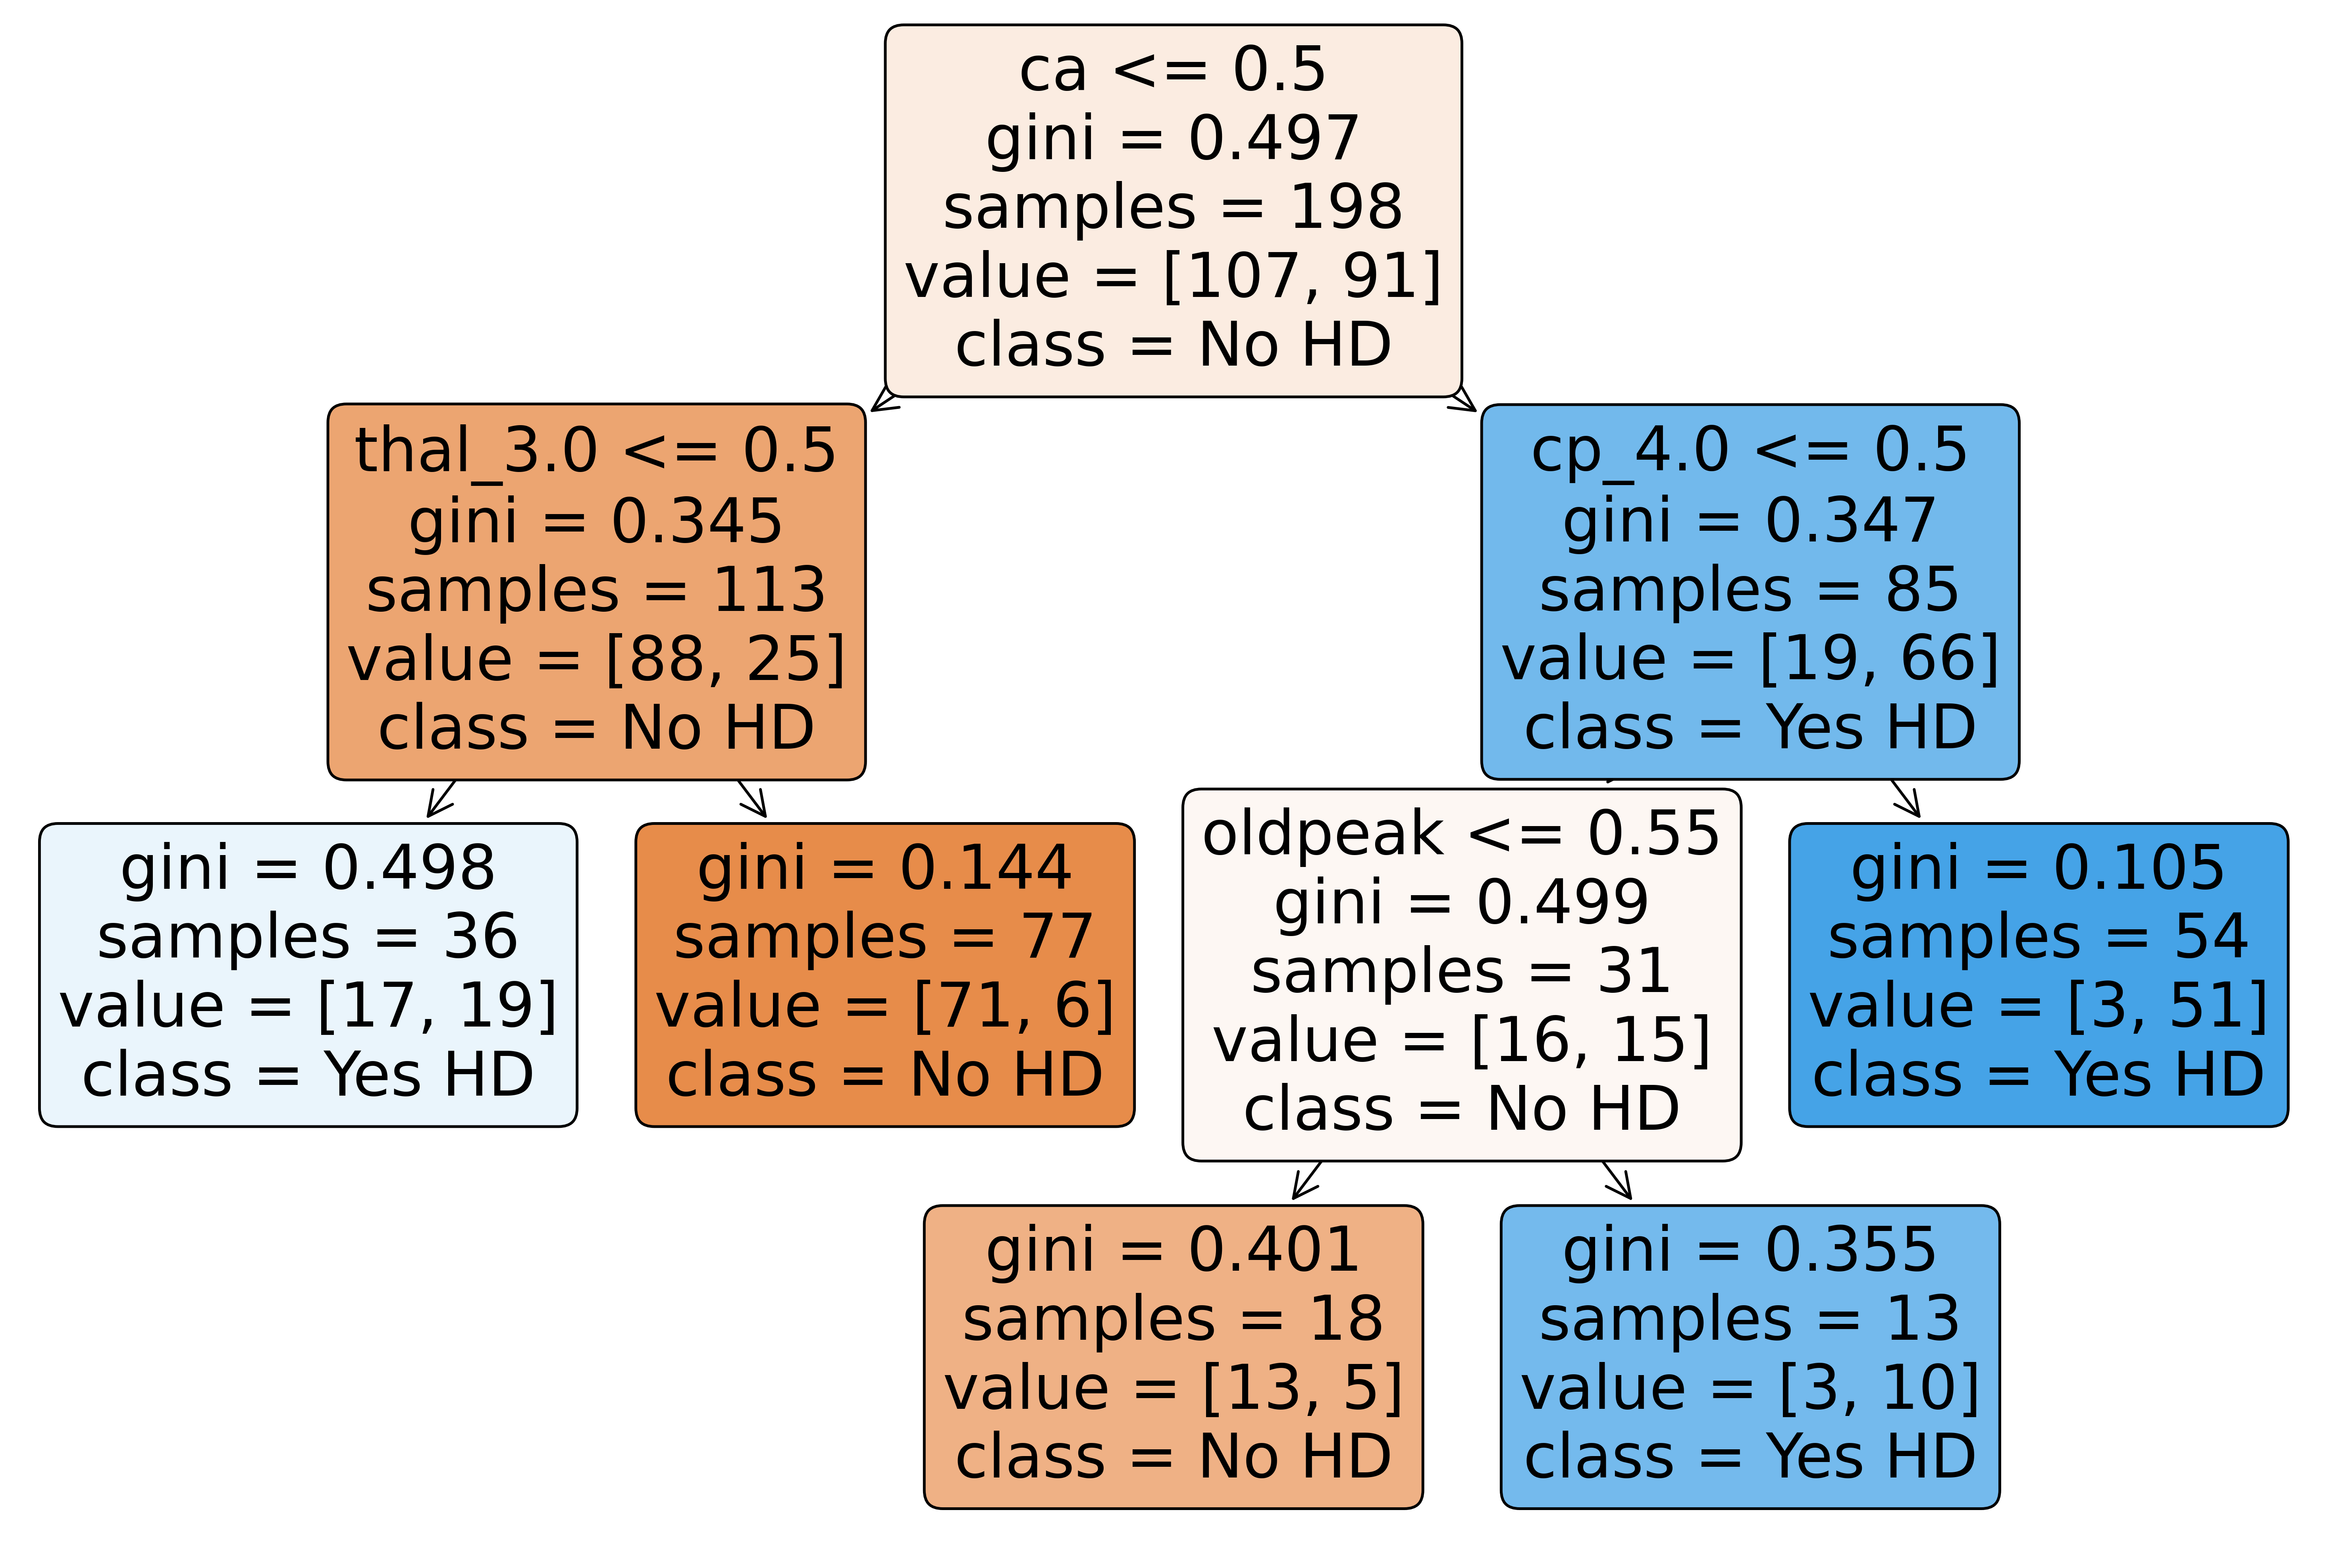

In [60]:
plt.figure(figsize=(15, 10), dpi=500)
plot_tree(clf_dt_pruned, filled=True, rounded=True,
          class_names=["No HD", "Yes HD"],
          feature_names=list(X_encoded.columns))

plt.show()